# Simulation

In [13]:
%%capture
!pip install -r requirements.txt

In [14]:
from qutip import basis, tensor, sigmax, sigmay, sigmaz, concurrence, entropy_vn, partial_transpose, rand_ket
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
ket_0 = basis(2, 0) #|0>
ket_1 = basis(2, 1) #|1>

# Bell state phi_plus = (|00>+|11>)/sqrt(2)
phi_plus = (tensor(ket_0, ket_0) + tensor(ket_1, ket_1)).unit()
# Bell state phi_minus = (|00> - |11>)/sqrt(2)
phi_minus = (tensor(ket_0, ket_0) - tensor(ket_1, ket_1)).unit()
# Bell state psi_plus = (|01>+|10>)/sqrt(2)
psi_plus = (tensor(ket_0, ket_1) + tensor(ket_1, ket_0)).unit()
# Bell state psi_minus = (|01>-|10>)/sqrt(2)
psi_minus = (tensor(ket_0, ket_1) - tensor(ket_1, ket_0)).unit()

bell_states = {"phi_plus" : phi_plus, 
          "phi_minus": phi_minus, 
          "psi_plus": psi_plus, 
          "psi_minus": psi_minus}

In [16]:
def is_entangled_chsh(state):
    A_1 = sigmaz()
    A_2 = sigmax()
    B_1 = (sigmaz() + sigmax()) / np.sqrt(2)
    B_2 = (sigmaz() - sigmax()) / np.sqrt(2)
    CHSH_ZX = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    A_1 = sigmay()
    A_2 = sigmaz()
    B_1 = (sigmay() + sigmaz()) / np.sqrt(2)
    B_2 = (sigmay() - sigmaz()) / np.sqrt(2)
    CHSH_YZ = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    A_1 = sigmax()
    A_2 = sigmay()
    B_1 = (sigmax() + sigmay()) / np.sqrt(2)
    B_2 = (sigmax() - sigmay()) / np.sqrt(2)
    CHSH_XY = tensor(A_1, B_1) + tensor(A_1, B_2) + tensor(A_2, B_1) - tensor(A_2, B_2)
    
    chsh_operators ={"CHSH_ZX": CHSH_ZX, "CHSH_YZ": CHSH_YZ, "CHSH_XY": CHSH_XY}

    for chsh_basis, chsh_operator in chsh_operators.items():
        violation = np.abs(state.dag() * chsh_operator * state)
        if violation > 2:
            return True
    return False

In [17]:
def is_entangled_concurrence(state):
    state_dm = state * state.dag() 
    conc = concurrence(state_dm)
    return conc != 0.0

In [18]:
def is_entangled_entropy(state, tolerance=1e-10):
    state_dm = state * state.dag() 
    ptrace = state_dm.ptrace(0) 
    entropy = entropy_vn(ptrace, base=2)
    return entropy > tolerance and entropy <= (1+tolerance)

In [19]:
def is_entangled_negativity(state, tolerance=1e-10):
    state_dm = state * state.dag()
    partial_transposed_state = partial_transpose(state_dm, [0, 1])
    eigenvalues = partial_transposed_state.eigenenergies()
    negativity = sum(abs(e) for e in eigenvalues if e < 0)
    return negativity > tolerance

In [20]:
def get_simulated_training_data(entanglement_witness, samples_nb=2000):
    samples_states = []
    samples_is_entangled = []
    
    for _ in range(0, samples_nb):
        # Create an entangled state in the form: cos(theta)|00> + exp(i*phi)*sin(theta)|11>
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        state = (np.cos(theta) * tensor(basis(2, 0), basis(2, 0)) +
                 np.exp(1j * phi) * np.sin(theta) * tensor(basis(2, 1), basis(2, 1)))
        samples_states.append(state)
        samples_is_entangled.append(entanglement_witness(state))
    
        # Create an entangled state in the form: cos(theta)|01> + exp(i*phi)*sin(theta)|01>
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        state = (np.cos(theta) * tensor(basis(2, 0), basis(2, 1)) +
                 np.exp(1j * phi) * np.sin(theta) * tensor(basis(2, 1), basis(2, 0)))
        samples_states.append(state)
        is_entangled = entanglement_witness(state)
        samples_is_entangled.append(is_entangled)
    
        # Create a separable state |psi> X |phi>
        state = tensor(rand_ket(2), rand_ket(2))
        samples_states.append(state)
        is_entangled = entanglement_witness(state)
        samples_is_entangled.append(is_entangled)

    return samples_states, samples_is_entangled

In [21]:
def get_model(samples_states, samples_is_entangled):
    data = np.array([np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]) for state in samples_states])
    labels = np.array(samples_is_entangled)     

    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(data.shape[1],)),  # Adjust input shape based on your data
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    model.evaluate(X_val, y_val)

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model

MODEL FOR ENTANGLEMENT WITNESS CHSH
Epoch 1/10


/home/faical/anaconda3/envs/quantum-entanglement/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7293 - loss: 0.5767 - val_accuracy: 0.7308 - val_loss: 0.4766
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.7895 - loss: 0.4197 - val_accuracy: 0.8475 - val_loss: 0.3419
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.8658 - loss: 0.3164 - val_accuracy: 0.8975 - val_loss: 0.2630
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.9080 - loss: 0.2346 - val_accuracy: 0.9292 - val_loss: 0.2068
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.9476 - loss: 0.1787 - val_accuracy: 0.9492 - val_loss: 0.1595
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9583 - loss: 0.1428 - val_accuracy: 0.9475 - val_loss: 0.1364
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.9662 - loss: 0.1172 - val_accuracy: 0.9633 - val_loss: 0.1110
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.9753 - loss: 0.0960 - val_accuracy:

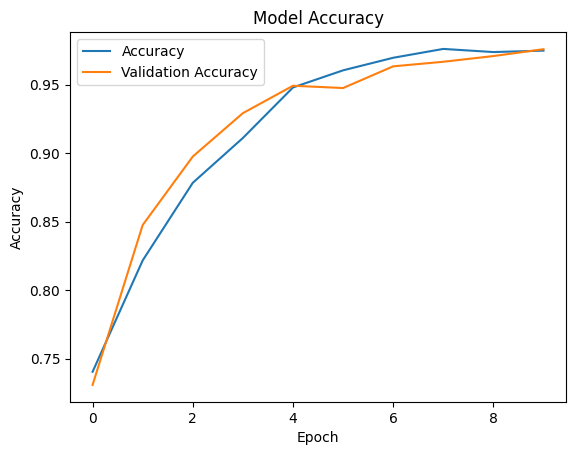

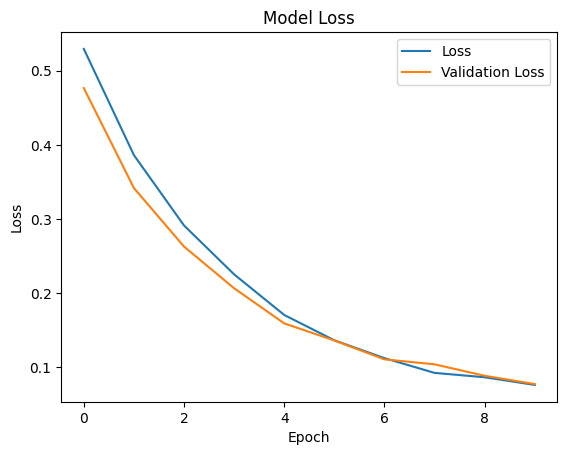

MODEL FOR ENTANGLEMENT WITNESS CONCURRENCE
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6823 - loss: 0.6033 - val_accuracy: 0.8442 - val_loss: 0.3762
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.9003 - loss: 0.2835 - val_accuracy: 0.9567 - val_loss: 0.1449
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.9610 - loss: 0.1202 - val_accuracy: 0.9733 - val_loss: 0.0960
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.9759 - loss: 0.0869 - val_accuracy: 0.9775 - val_loss: 0.0721
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.9848 - loss: 0.0582 - val_accuracy: 0.9892 - val_loss: 0.0629
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.9854 - loss: 0.0786 - val_accuracy: 0.9917 - val_loss: 0.0533
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.9846 - loss: 0.0739 - val_accuracy: 0.9867 - val_loss: 0.0480
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/

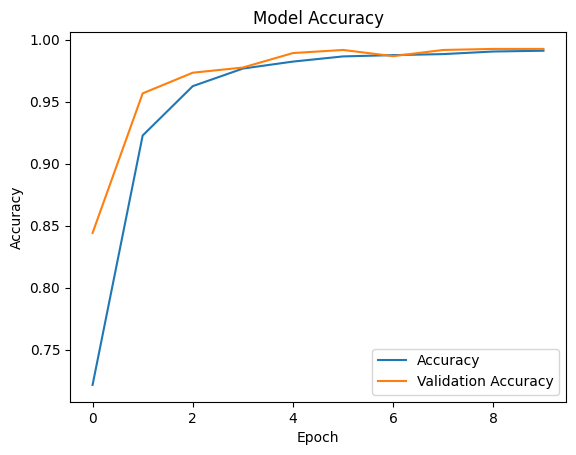

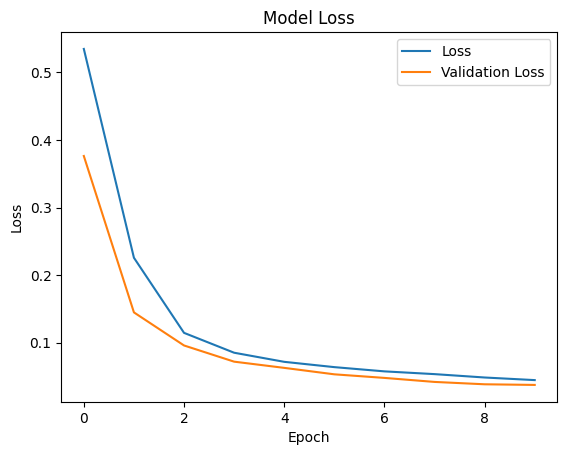

MODEL FOR ENTANGLEMENT WITNESS ENTROPY
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6651 - loss: 0.6140 - val_accuracy: 0.8242 - val_loss: 0.4269
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.8774 - loss: 0.3261 - val_accuracy: 0.9458 - val_loss: 0.1555
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.9569 - loss: 0.1217 - val_accuracy: 0.9733 - val_loss: 0.0816
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.9799 - loss: 0.0636 - val_accuracy: 0.9817 - val_loss: 0.0568
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.9862 - loss: 0.0426 - val_accuracy: 0.9842 - val_loss: 0.0489
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.9869 - loss: 0.0394 - val_accuracy: 0.9892 - val_loss: 0.0402
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.9927 - loss: 0.0242 - val_accuracy: 0.9892 - val_loss: 0.0347
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step

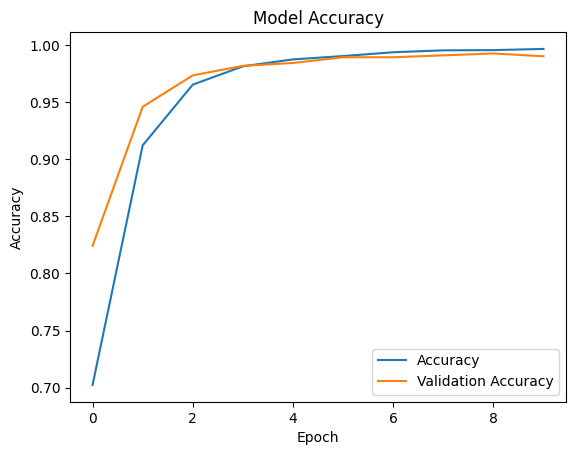

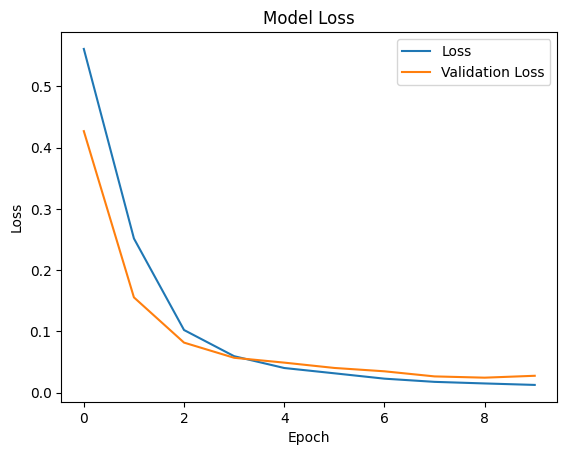

MODEL FOR ENTANGLEMENT WITNESS NEGATIVITY
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6766 - loss: 0.5988 - val_accuracy: 0.8417 - val_loss: 0.3938
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.8904 - loss: 0.3024 - val_accuracy: 0.9642 - val_loss: 0.1336
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.9618 - loss: 0.1198 - val_accuracy: 0.9775 - val_loss: 0.0704
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9805 - loss: 0.0661 - val_accuracy: 0.9858 - val_loss: 0.0440
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9857 - loss: 0.0489 - val_accuracy: 0.9933 - val_loss: 0.0336
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.9897 - loss: 0.0315 - val_accuracy: 0.9933 - val_loss: 0.0247
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.9934 - loss: 0.0251 - val_accuracy: 0.9933 - val_loss: 0.0189
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/ste

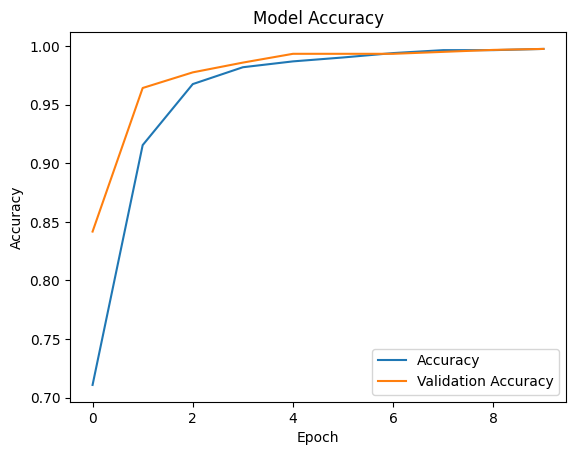

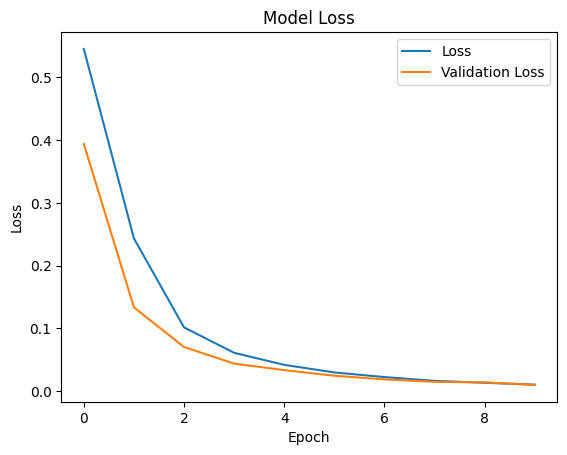

In [22]:
entanglement_witnesses = {"CHSH": is_entangled_chsh, "CONCURRENCE": is_entangled_concurrence, "ENTROPY": is_entangled_entropy, "NEGATIVITY": is_entangled_negativity}
models = {}

for name, witness in entanglement_witnesses.items():
    print("MODEL FOR ENTANGLEMENT WITNESS", name)
    samples_states, samples_is_entangled =  get_simulated_training_data(witness)
    model = get_model(samples_states, samples_is_entangled)
    models[name] = {"model": model, "witness": witness}


In [23]:
for name, model_data in models.items():
    model = model_data["model"]
    witness = model_data["witness"]
    
    print("\n----------", "\nTESTS FOR MODEL", name)
    
    print("\nTESTS FOR ENTANGLED (BELL) STATES")
    for state_name, state in bell_states.items():
        single_data = np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]).reshape(1, -1)
        predicted = model.predict(single_data)
        print("Predicted probability of {} being entangled: {}".format(state_name, predicted[0][0]))
        print("Is the state entangled [{}]: ".format(witness.__name__), witness(state))
    
    print("\nTESTS FOR NON-ENTANGLED STATES")
    for _ in range(0, 4):
        state = tensor(rand_ket(2), rand_ket(2))
        single_data = np.concatenate([state.full().real.flatten(), state.full().imag.flatten()]).reshape(1, -1)
        predicted = model.predict(single_data)
        print("Predicted probability of {} being entangled: {}".format(state, predicted[0][0]))
        print("Is the state entangled [{}]: ".format(witness.__name__), witness(state))


---------- 
TESTS FOR MODEL CHSH

TESTS FOR ENTANGLED (BELL) STATES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted probability of phi_plus being entangled: 0.9994760751724243
Is the state entangled [is_entangled_chsh]:  True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted probability of phi_minus being entangled: 0.9978559613227844
Is the state entangled [is_entangled_chsh]:  True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted probability of psi_plus being entangled: 0.9963575005531311
Is the state entangled [is_entangled_chsh]:  True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted probability of psi_minus being entangled: 0.9997843503952026
Is the state entangled [is_entangled_chsh]:  True

TESTS FOR NON-ENTANGLED STATES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted probability of Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.47998187+0.48036221j]
 [0.14676336+0.17942296j]
 [0.29254483-0.5906988j ]
 [0.11937759-0.19073255j]] being en